In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf
import itertools

VSUN = np.array([10.0, 11.0, 7.0])
nu, nv, nw = 100, 100, 100
sr = 100.

pi = np.pi
OUMUAMUA_COORDS = [np.radians(279.804), np.radians(33.997)]            # from Mamajek (2017)

write_grid = True

s1, s2, s3 = 26., 18., 15.    # for G stars
vd = np.radians(12.)

In [2]:
def ga2equ(ga):
    pole_ra = np.radians(192.859508)
    pole_dec = np.radians(27.128336)
    posangle = np.radians(122.932-90.)
    
    ra = np.arctan2(np.cos(ga[1])*np.cos(ga[0]-posangle), \
                    np.sin(ga[1])*np.cos(pole_dec) - np.cos(ga[1])*np.sin(pole_dec)*np.sin(ga[0]-posangle)) + pole_ra
    dec = np.arcsin(np.cos(ga[1])*np.cos(pole_dec)*np.sin(ga[0]-posangle) + np.sin(ga[1])*np.sin(pole_dec))
    
    return np.array([ra, dec])

def get_prob(vgal, dv, s1, s2, s3, vd):
    vLSR = vgal + VSUN
    v = np.array([vLSR[0]*np.cos(vd) + vLSR[1]*np.sin(vd), -vLSR[0]*np.sin(vd) + vLSR[1]*np.cos(vd), vLSR[2]])
    
    return 1./8.*(erf((v[0]+dv[0])/(np.sqrt(2)*s1)) - erf((v[0]-dv[0])/(np.sqrt(2)*s1)))* \
           (erf((v[1]+dv[1])/(np.sqrt(2)*s2)) - erf((v[1]-dv[1])/(np.sqrt(2)*s2)))* \
           (erf((v[2]+dv[2])/(np.sqrt(2)*s3)) - erf((v[2]-dv[2])/(np.sqrt(2)*s3)))

def galacticV_to_ra_dec(vel):
    vel = -np.array(vel)
    l = np.arctan2(vel[1], vel[0])
    b = np.arctan2(vel[2], np.sqrt(vel[0]**2 + vel[1]**2))
    return ga2equ([l, b])

def prob_weight(vel, phi):
    return 1. + (42./(np.linalg.norm(vel) + phi))**2

In [3]:
ug = np.linspace(-sr, sr+1., nu)
vg = np.linspace(-sr, sr+1., nv)
wg = np.linspace(-sr, sr+1., nw)

vgal = np.array(list(itertools.product(ug, vg, wg)))
print(vgal.shape)

(1000000, 3)


In [4]:
if write_grid == True:
    prob = np.zeros(nu*nv*nw)
    unfocused_prob = np.zeros_like(prob)
    skyra = np.zeros_like(prob)
    skydec = np.zeros_like(prob)
    
    for i, v in enumerate(vgal):
        if i % 100000 == 0:
            print(i)
        coords = galacticV_to_ra_dec(v)
        skyra[i] = coords[0]
        skydec[i] = coords[1]
        prob[i] = prob_weight(v, 2.)*get_prob(v, [sr/nu, sr/nv, sr/nw], s1, s2, s3, vd)
        unfocused_prob[i] = get_prob(v, [sr/nu, sr/nv, sr/nw], s1, s2, s3, vd)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000


In [5]:
MAINPATH = 'C:/Users/djhoo/Documents/ISO/distribution_function/'
if write_grid == True:
    np.savetxt(MAINPATH + 'grid_data.txt', np.column_stack((skyra, skydec, prob, unfocused_prob)))
else:
    grid_data = np.loadtxt(MAINPATH + 'grid_data.txt')
    skyra = grid_data[:, 0]
    skydec = grid_data[:, 1]
    prob = grid_data[:, 2]
    unfocused_prob = grid_data[:, 3]

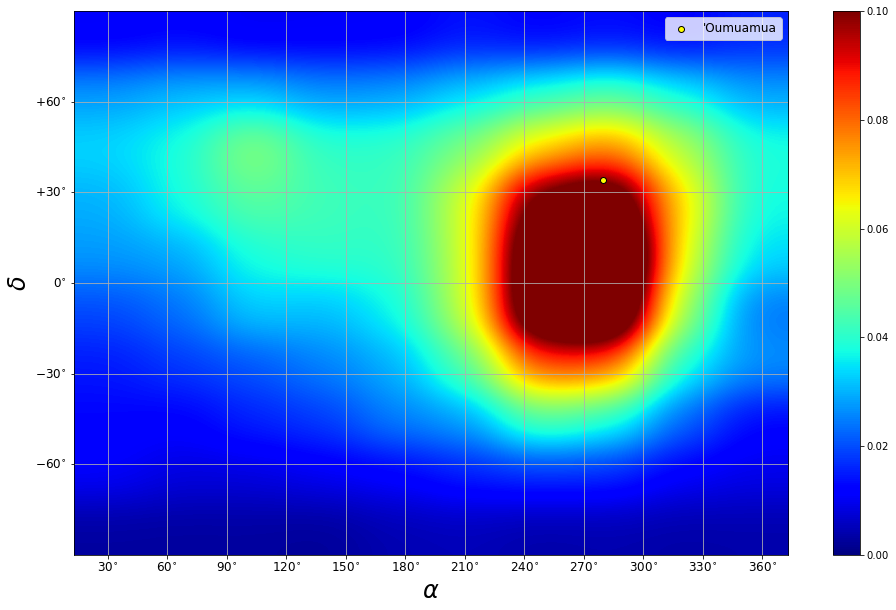

In [6]:
plt.figure(figsize=(16, 10))

h, xedges, yedges = np.histogram2d(skyra, skydec, bins=10, weights=prob)
plt.imshow(h.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], \
           interpolation='gaussian', aspect='auto', cmap='jet', vmin=0., vmax=0.1)
plt.colorbar()

plt.xlabel(r'$\alpha$', fontsize=24)
plt.xticks([0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6, pi, 7*pi/6, 4*pi/3, 3*pi/2, 5*pi/3, 11*pi/6, 2*pi], \
           [r'$0^{\circ}$', r'$30^{\circ}$', r'$60^{\circ}$', r'$90^{\circ}$', r'$120^{\circ}$', r'$150^{\circ}$', \
            r'$180^{\circ}$', r'$210^{\circ}$', r'$240^{\circ}$', r'$270^{\circ}$', r'$300^{\circ}$', r'$330^{\circ}$', \
            r'$360^{\circ}$'], fontsize=12)

plt.ylabel(r'$\delta$', fontsize=24)
plt.yticks([-pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2], [r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', \
        r'$0^{\circ}$', r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$'], fontsize=12)
plt.grid(True)

plt.scatter(OUMUAMUA_COORDS[0], OUMUAMUA_COORDS[1], c='yellow', edgecolor='k', label="'Oumuamua")
plt.legend(loc='upper right', fontsize=12)

plt.show()

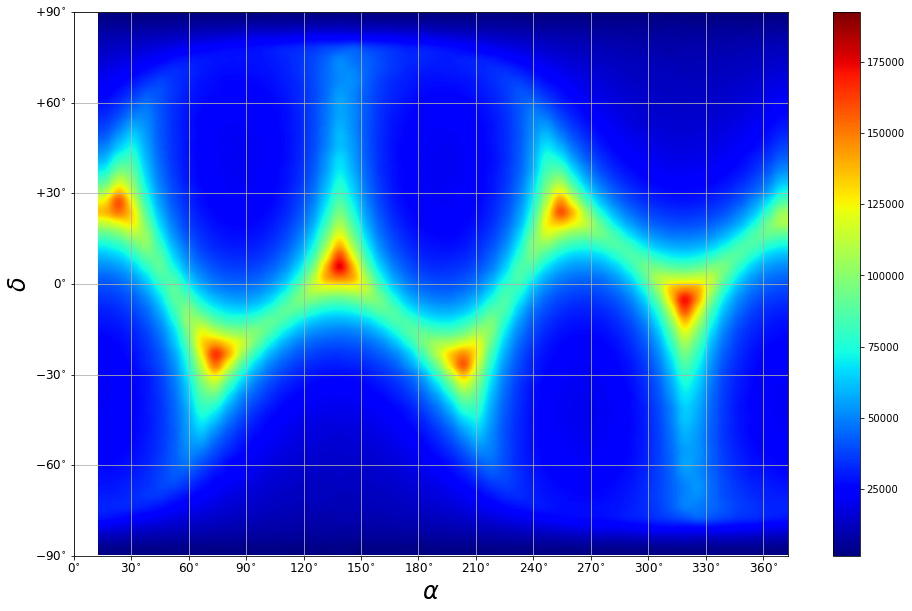

In [7]:
speed_init = np.sqrt(np.sum(vgal**2, axis=1))

plt.figure(figsize=(16,10))

h, xedges, yedges = np.histogram2d(skyra, skydec, bins=50, \
                                  weights=speed_init)
plt.imshow(h.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], \
          interpolation='gaussian', aspect='auto', cmap='jet')
plt.colorbar()
plt.grid(True)

plt.xlabel(r'$\alpha$', fontsize=24)
plt.xticks([0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6, pi, 7*pi/6, 4*pi/3, 3*pi/2, 5*pi/3, 11*pi/6, 2*pi], \
           [r'$0^{\circ}$', r'$30^{\circ}$', r'$60^{\circ}$', r'$90^{\circ}$', r'$120^{\circ}$', r'$150^{\circ}$', \
            r'$180^{\circ}$', r'$210^{\circ}$', r'$240^{\circ}$', r'$270^{\circ}$', r'$300^{\circ}$', r'$330^{\circ}$', \
            r'$360^{\circ}$'], fontsize=12)

plt.ylabel(r'$\delta$', fontsize=24)
plt.yticks([-pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2], [r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', \
        r'$0^{\circ}$', r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$'], fontsize=12)

plt.show()

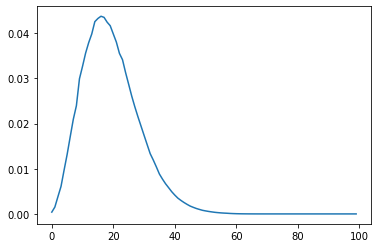

In [8]:
hist, bin_edges = np.histogram(speed_init, weights=unfocused_prob, bins=100)
plt.plot(hist)
plt.show()

In [9]:
from scipy.interpolate import NearestNDInterpolator
from scipy.optimize import differential_evolution

NSAMPLES = 10000
interp = NearestNDInterpolator(vgal, prob)

In [10]:
def diff(v, P):
    return abs(interp(v) - P)

def get_velocities(nsamples=1000):
    P = np.random.uniform(low=min(prob), high=max(prob), size=nsamples)
    vel = np.zeros((nsamples, 3))
    for i, p in enumerate(P):
        if i % (NSAMPLES/10) == 0:
            print(i)
        res = differential_evolution(diff, [(-100., 100.), (-100., 100.), (-100., 100.)], args=(p,))
        vel[i] = res.x
    return vel
        
vgal_sample = get_velocities(nsamples=NSAMPLES)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [11]:
skyra_sample = np.zeros(NSAMPLES)
skydec_sample = np.zeros_like(skyra_sample)

for i, v in enumerate(vgal_sample):
    coords = galacticV_to_ra_dec(v)
    skyra_sample[i] = coords[0]
    skydec_sample[i] = coords[1]

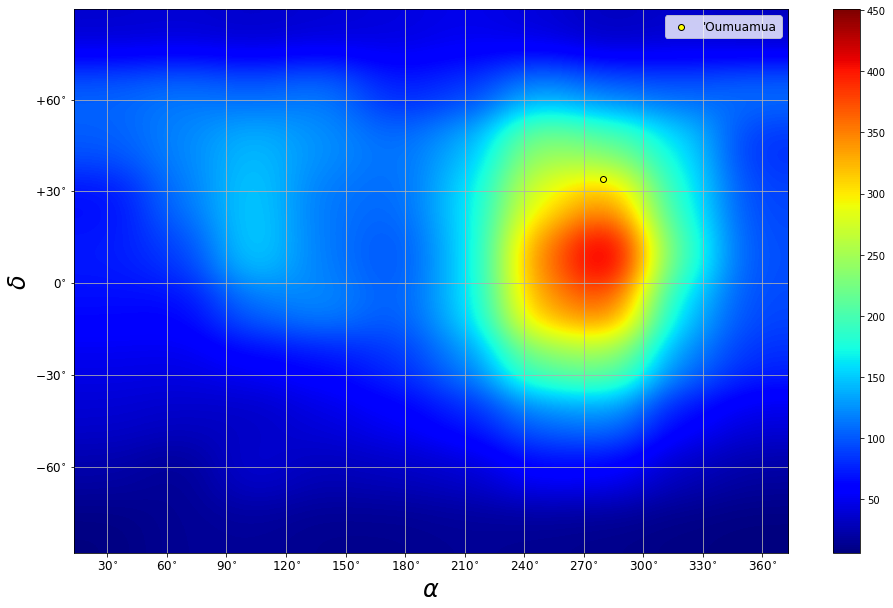

In [12]:
plt.figure(figsize=(16, 10))

h, xedges, yedges = np.histogram2d(skyra_sample, skydec_sample, bins=10)
plt.imshow(h.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], \
           interpolation='gaussian', aspect='auto', cmap='jet')
plt.colorbar()

plt.xlabel(r'$\alpha$', fontsize=24)
plt.xticks([0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6, pi, 7*pi/6, 4*pi/3, 3*pi/2, 5*pi/3, 11*pi/6, 2*pi], \
           [r'$0^{\circ}$', r'$30^{\circ}$', r'$60^{\circ}$', r'$90^{\circ}$', r'$120^{\circ}$', r'$150^{\circ}$', \
            r'$180^{\circ}$', r'$210^{\circ}$', r'$240^{\circ}$', r'$270^{\circ}$', r'$300^{\circ}$', r'$330^{\circ}$', \
            r'$360^{\circ}$'], fontsize=12)

plt.ylabel(r'$\delta$', fontsize=24)
plt.yticks([-pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2], [r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', \
        r'$0^{\circ}$', r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$'], fontsize=12)
plt.grid(True)

plt.scatter(OUMUAMUA_COORDS[0], OUMUAMUA_COORDS[1], c='yellow', edgecolor='k', label="'Oumuamua")
plt.legend(loc='upper right', fontsize=12)

plt.show()

In [13]:
np.savetxt(MAINPATH + 'vgal.txt', vgal_sample)

In [14]:
print('Writing complete!')

Writing complete!
